# Počet foci v závislosti na roztoku
### TODO: význam dat

Data jsou mereni na urovni jednotlivych bunek ("Cells.csv"), jednotlivych foci ("Foci.csv") a na urovni jamek ("Cells Stats.csv"). Vyhodnocovat se bude pocet foci na bunku (sloupec "(Foci (Nuclei)) COUNT" v souboru "Cells.csv"), jde o zhodnoceni charakteru techto dat a zpusobu porovnavani dat mezi sebou. Metadata k jamkam jsou v souboru "Cells Stats.csv" - sloupec "Compound" oznacuje typ deplece, non-treated NT, nebo nazev siRNA, sloupec "Dose" je koncentrace dalsiho treatmentu CPT 

https://owncloud.cesnet.cz/index.php/s/UgSV5MbtenDWMf2

Ve screenu se budou porovnavat siRNA pro CPT treatment zvlast. Z-prime bude vyhodnoceny pro negativni kontrolu (napr. siLuc) vuci pozitivni kontrole (napr. siDDX17). 

V mezicase se podivam do literatury a zjistim, jak se pocty foci vyhodnocuji v jinych HCS screenech.


## Imports and data loading

In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotnine as p9
# p9.options.figure_size = (6,4)
from plotnine import *
p9.theme_set(p9.theme_light) # minimal
import scipy
from scipy import stats
import statsmodels.api as sm
import random
# import pingouin as pg
# import researchpy as rp
import seaborn as sns
import sklearn

## Imports and data loading

In [67]:
labels = pd.read_csv('Cell_Stats.csv')
labels.head()

,ID,MeasurementTitle,PlateName,WellID,Row,Column,RowName,ColumnName,WellName,Compound,...,[Cell] (Foci (Nuclei)) TotalIntensity CH2 AVG (AVG),[Cell] (Foci (Nuclei)) TotalIntensity CH2 AVG (SD),[Cell] (Foci (Nuclei)) TotalIntensity CH2 MEDIAN (AVG),[Cell] (Foci (Nuclei)) TotalIntensity CH2 MEDIAN (SD),[Cell] (Foci (Nuclei)) MeanIntensity CH2 AVG (AVG),[Cell] (Foci (Nuclei)) MeanIntensity CH2 AVG (SD),[Cell] (Foci (Nuclei)) MeanIntensity CH2 MEDIAN (AVG),[Cell] (Foci (Nuclei)) MeanIntensity CH2 MEDIAN (SD),[Cell] Focci intensity norm (AVG),[Cell] Focci intensity norm (SD)
0,1,Aurora 384_jd foci siRNA SP TP-JD035_20230209_...,TP-JD035,128,6,8,F,8,F-08,NT,...,27071.56,6465.51,20600.66,6340.89,1297.7066,218.6880,1145.1269,217.5890,111.264679,53.644325
1,57,Aurora 384_jd foci siRNA SP TP-JD035_20230209_...,TP-JD035,129,6,9,F,9,F-09,siCON1,...,28823.60,7517.91,22415.63,7871.88,1332.1009,240.6524,1194.7287,252.2252,143.537641,86.033061
2,19,Aurora 384_jd foci siRNA SP TP-JD035_20230209_...,TP-JD035,130,6,10,F,10,F-10,siCON2,...,30752.28,9439.02,24581.50,9486.04,1374.9472,293.4447,1253.3712,298.9371,142.481245,91.257556
3,41,Aurora 384_jd foci siRNA SP TP-JD035_20230209_...,TP-JD035,131,6,11,F,11,F-11,siLuc,...,33115.41,10845.64,27221.47,11869.52,1449.6688,309.8516,1346.2094,350.9527,154.251397,83.046946
4,6,Aurora 384_jd foci siRNA SP TP-JD035_20230209_...,TP-JD035,132,6,12,F,12,F-12,siPLK1,...,8510.35,9870.18,7564.84,8909.15,496.9593,452.1947,473.6609,426.6811,85.026263,125.576196


In [68]:
labels = pd.read_csv('Cell_Stats.csv')[['WellID', 'Compound', 'Dose']]
labels.head()

,WellID,Compound,Dose
0,128,NT,0
1,129,siCON1,0
2,130,siCON2,0
3,131,siLuc,0
4,132,siPLK1,0


In [15]:
labels['Compound'].value_counts()

Compound
NT         12
siCON1      6
siCON2      6
siLuc       6
siPLK1      6
siDDX17     6
siSETX      6
siMSH3      6
siTHOC1     6
Name: count, dtype: int64

Vypsali jsme si počty jamek obsahujících všechny sloučeniny. Máme 9 sloučenin a každou až na kontrolu obsahuje 6 jamek. 3 z toho jsou pak s "Dose"=100 (koncentrace dalsiho treatmentu CPT)

In [16]:
cols = ['WellID', 'AreaIndex', '(Foci (Nuclei)) COUNT'
        # '(Nuclei) MinX', '(Nuclei) MaxX', '(Nuclei) MinY', '(Nuclei) MaxY',
        # '(Nuclei) X-CoordinateInWell', '(Nuclei) Y-CoordinateInWell',
]
cells = pd.read_csv('Cell.csv')[cols]
cells

df = cells.merge(labels).rename({'(Foci (Nuclei)) COUNT':'Count', 'WellID':'Well'}, axis=1)
df

,Well,AreaIndex,Count,Compound,Dose
0,128,1,2,NT,0
1,128,1,5,NT,0
2,128,1,40,NT,0
3,128,1,55,NT,0
4,128,1,29,NT,0
...,...,...,...,...,...
137638,257,100,106,NT,100
137639,257,100,70,NT,100
137640,257,100,282,NT,100
137641,257,100,58,NT,100


In [ ]:
Bude nás zajímat víceméně pouze tabulka Cell.csv, kde máme data nejpodrobnější a kde můžeme snadno zjistit, kolik foci obsahují jednotlivé buňky v každé jamce.

In [ ]:
TODO: jamka může obsahovat méně buněk, které ale průměrně budou mít vyšši počet foci. je to problém?

## Preprocessing

převedeme jamky a sloučeniny na kategoriální proměnné

In [18]:
df["Well"] = df["Well"].astype('category')
df["Compound"] = df["Compound"].astype('category')

df

,Well,AreaIndex,Count,Compound,Dose
0,128,1,2,NT,0
1,128,1,5,NT,0
2,128,1,40,NT,0
3,128,1,55,NT,0
4,128,1,29,NT,0
...,...,...,...,...,...
137638,257,100,106,NT,100
137639,257,100,70,NT,100
137640,257,100,282,NT,100
137641,257,100,58,NT,100


## Analýza dat

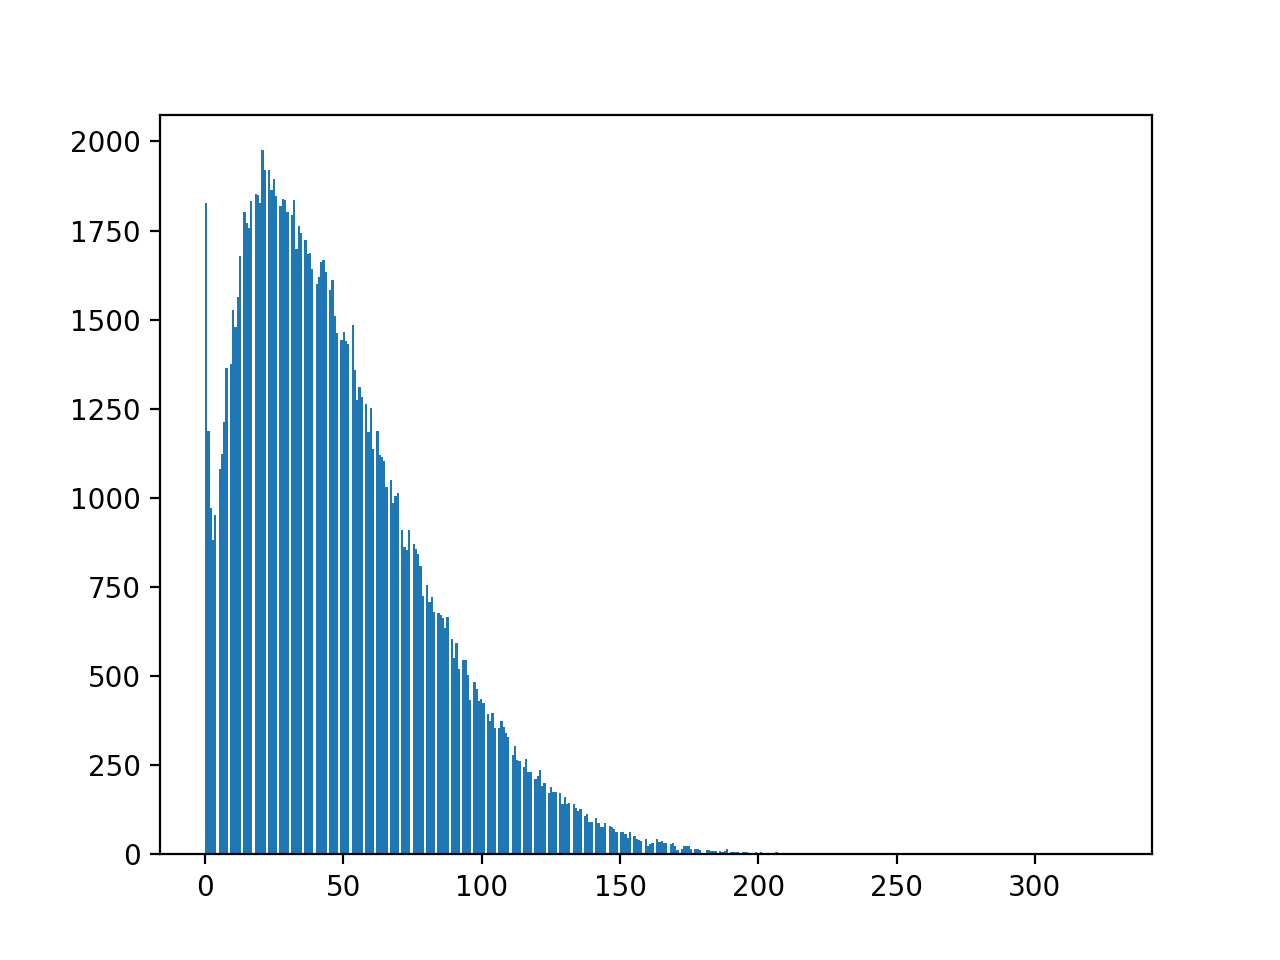

In [72]:
plt.hist(df['Count'], 400);

počty buněk s daným množstvím foci - napříč všemi sloučeninami

C:\Users\lordo\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 188'. Pick better value with 'binwidth'.


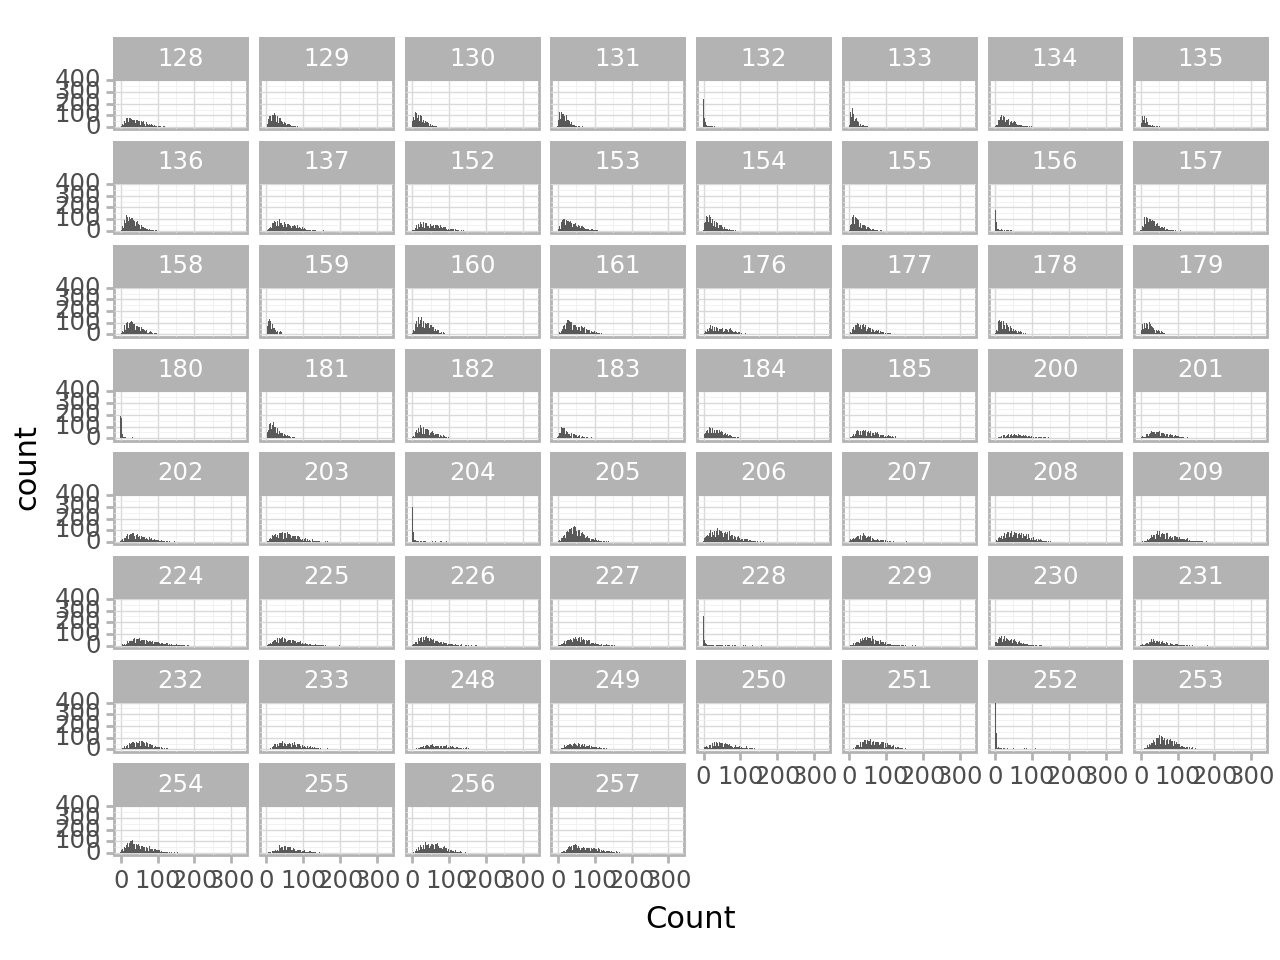

<Figure Size: (640 x 480)>

In [73]:
(ggplot(df)
 + aes(x = 'Count')
 + geom_histogram()
 + facet_wrap('Well') # rozdeli podle jamicek na grafy
)

Takto by vypadaly počty foci v buňkách pro jednotlivé jamky.
Otázkou nyní je, jestli by se dala spojit dohromady data z jamek, které obsahují stejnou sloučeninu.

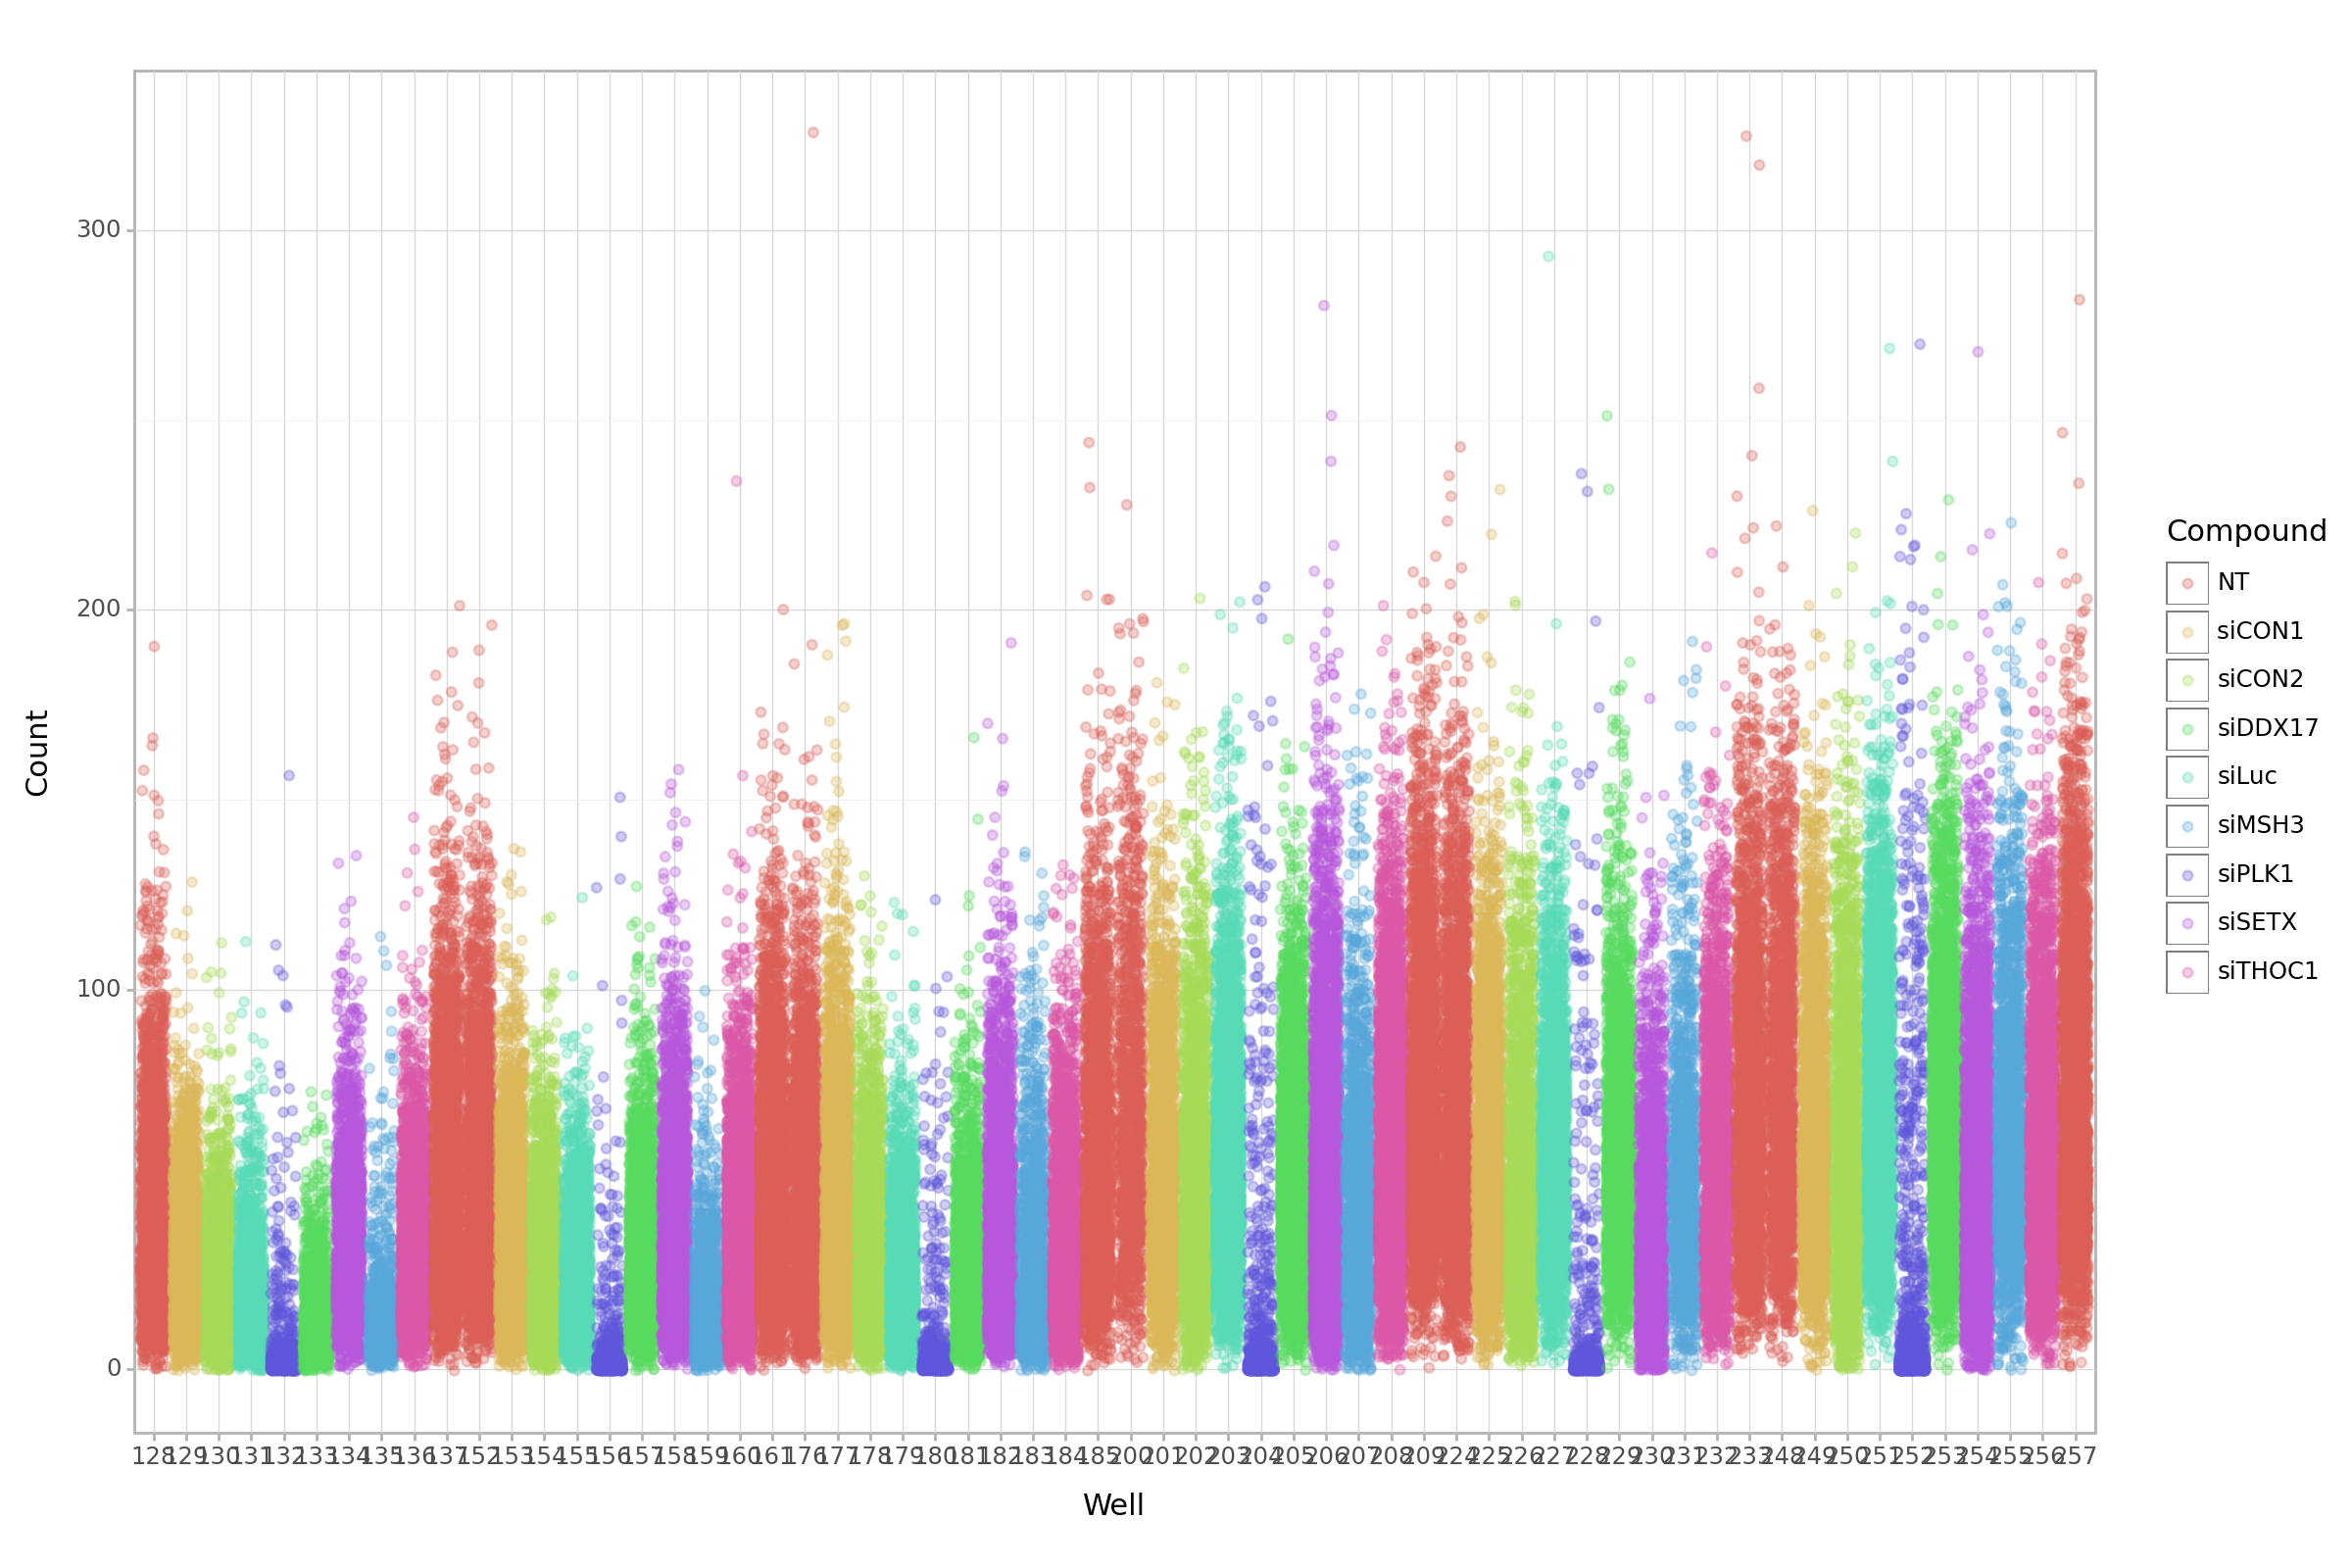

<Figure Size: (1200 x 800)>

In [19]:
(ggplot(df)
 + aes(x="Well", y='Count', color='Compound')
 + geom_jitter(alpha=.3) # jitter = position of the point
 + theme(figure_size=(12,8))
)

Tady je vizuálně pěknější graf, kde jde dobře vidět, jak se liší počty foci v buňkách pro různé sloučeniny a jak se naopak podobají pro stejné (pro se stejnou Dose)

In [24]:
well_128 = df.query('Well==128')

In [56]:
dose_0 = df.query('Dose==0')
dose_0

,Well,AreaIndex,Count,Compound,Dose
0,128,1,2,NT,0
1,128,1,5,NT,0
2,128,1,40,NT,0
3,128,1,55,NT,0
4,128,1,29,NT,0
...,...,...,...,...,...
64290,185,100,31,NT,0
64291,185,100,25,NT,0
64292,185,100,30,NT,0
64293,185,100,28,NT,0


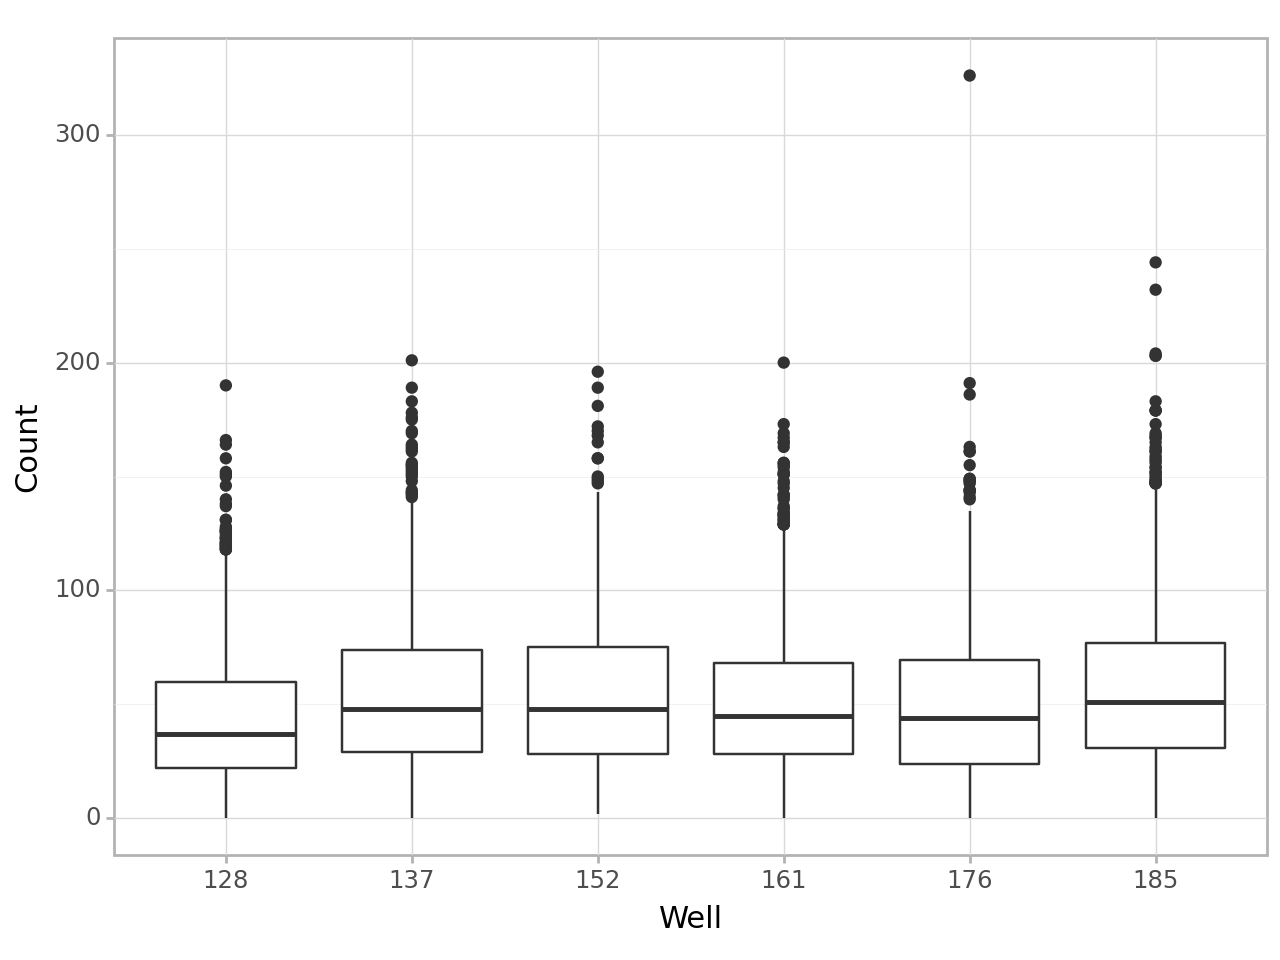

<Figure Size: (640 x 480)>

In [53]:
(ggplot(nt)
 + aes(x = 'Well', y='Count')
 + geom_boxplot()
)

Podíváme se nyní blíže na naměřená data z jamek obsahujících kontrolu






TODO kde se vzalo to nt


























In [52]:
nt['Count']

0         2
1         5
2        40
3        55
4        29
         ..
64290    31
64291    25
64292    30
64293    28
64294    21
Name: Count, Length: 15416, dtype: int64

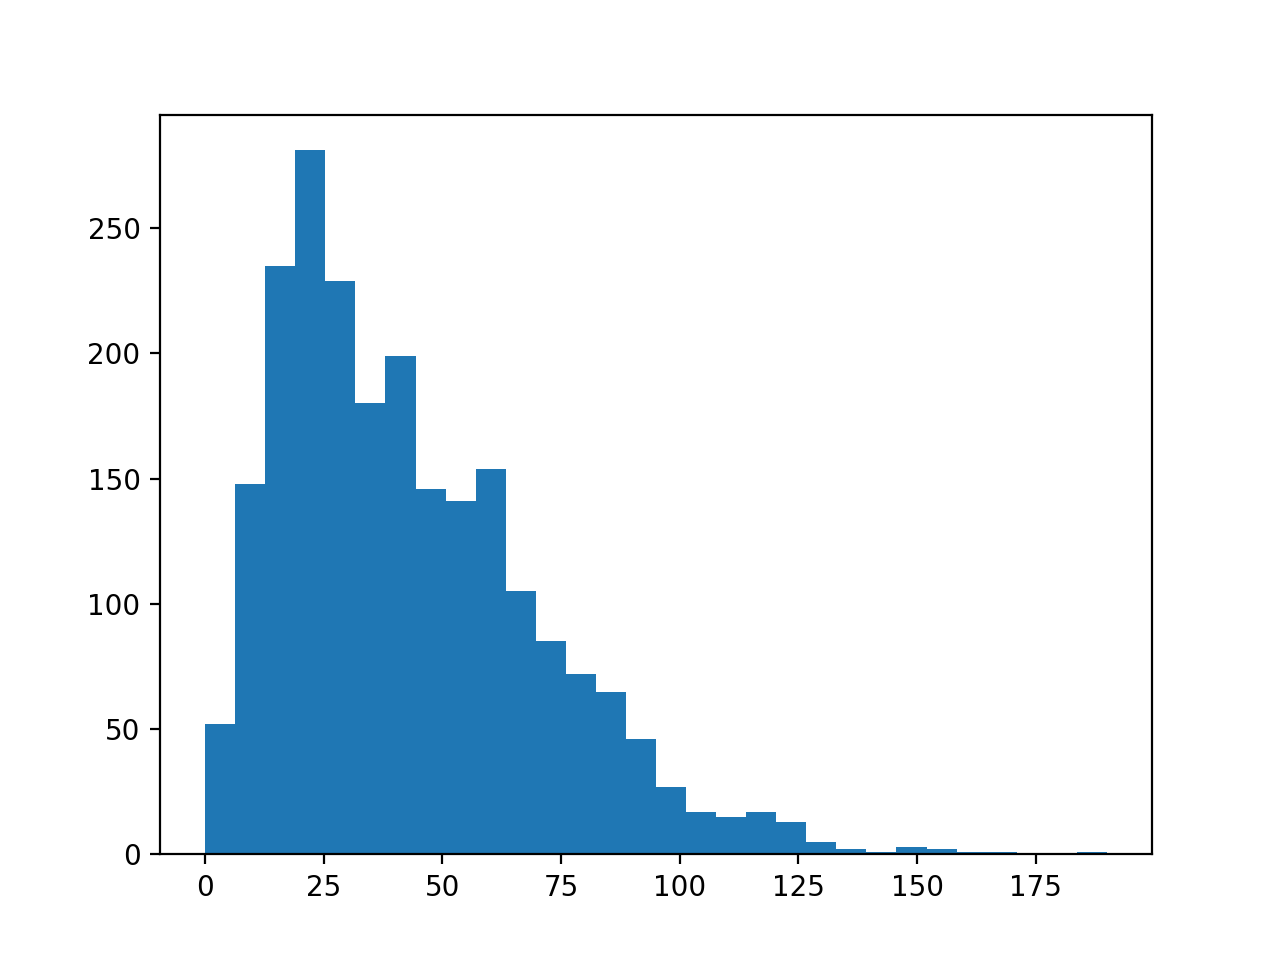

In [28]:
plt.hist(well_128['Count'], bins=30);

In [ ]:
(
    ggplot(df_test)
    + aes(x="date", y="Count")
    + scale_x_timedelta(name="Years since 1970")
    + labs(title="Population Evolution", y="Population")
    + geom_line()
)

In [ ]:
# rozdělíme podle jednotlivých compounds

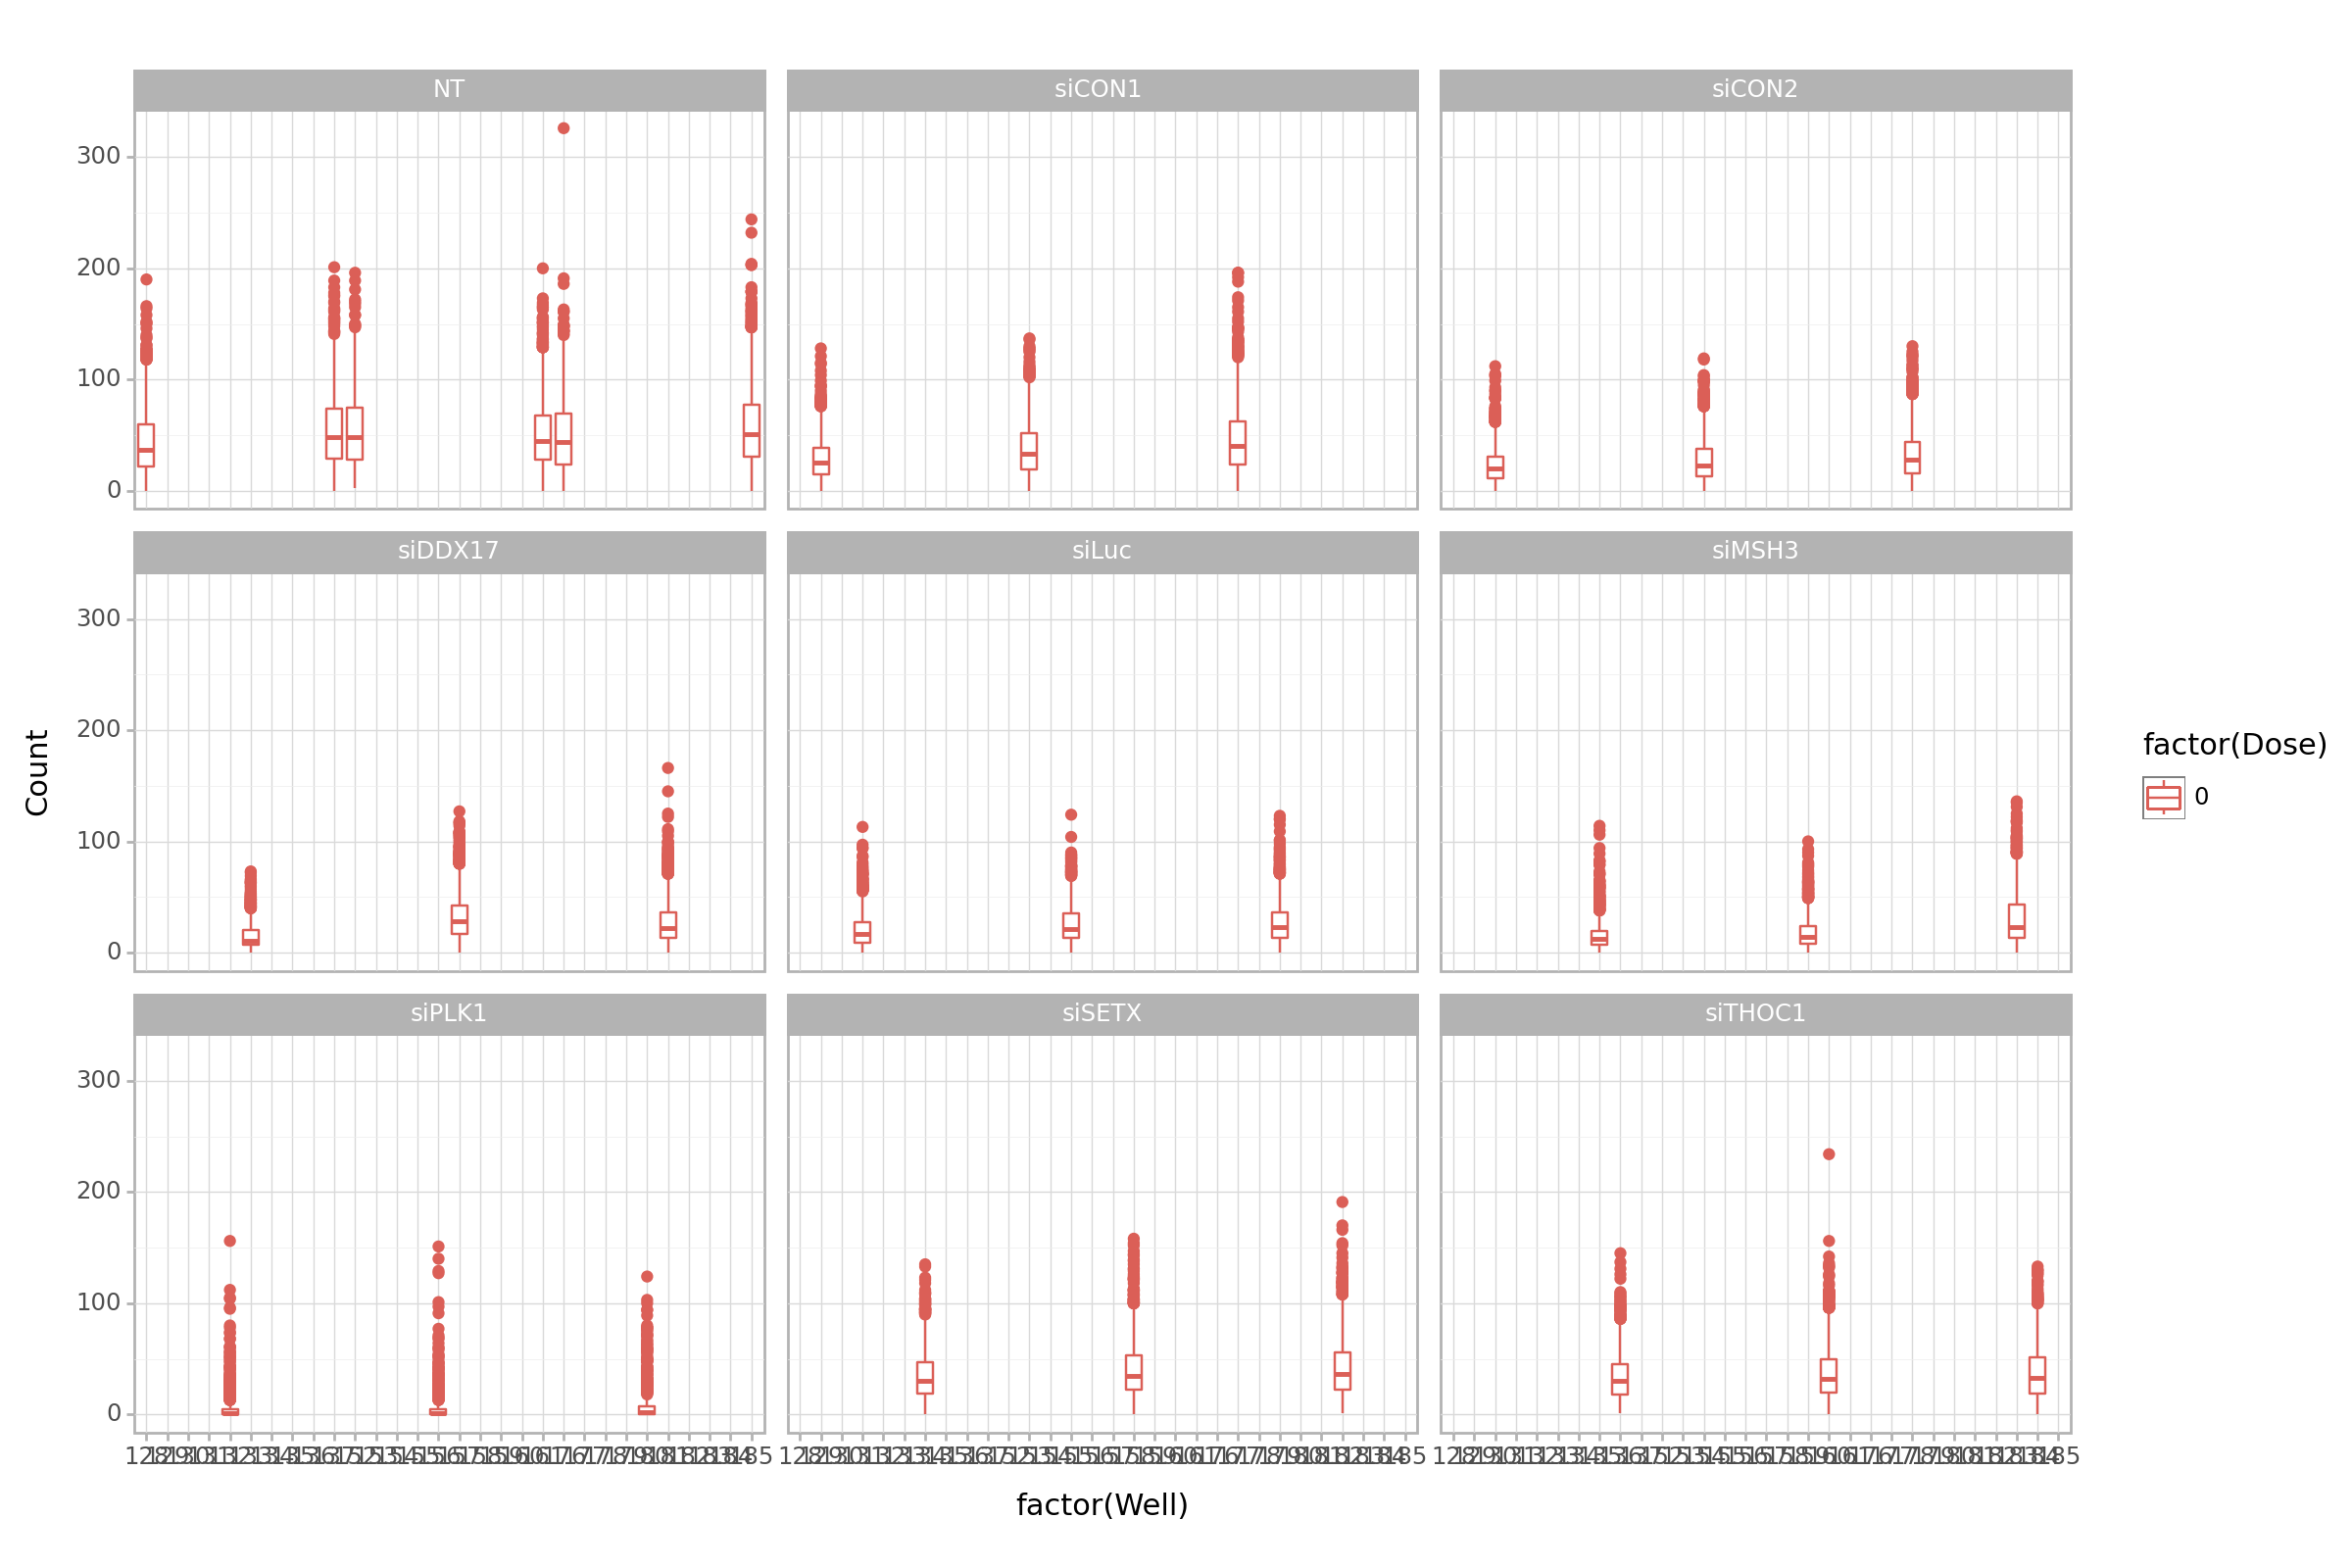

<Figure Size: (1200 x 800)>

In [63]:
(
    ggplot(dose_0, aes(x='factor(Well)', y='Count',  color='factor(Dose)'))
    #+ geom_point()
    #+ geom_jitter(alpha=.3)
    + geom_boxplot()
    + facet_wrap('Compound')
    + labs(x='factor(Well)', y='Count')
    + theme(figure_size=(12,8))
)

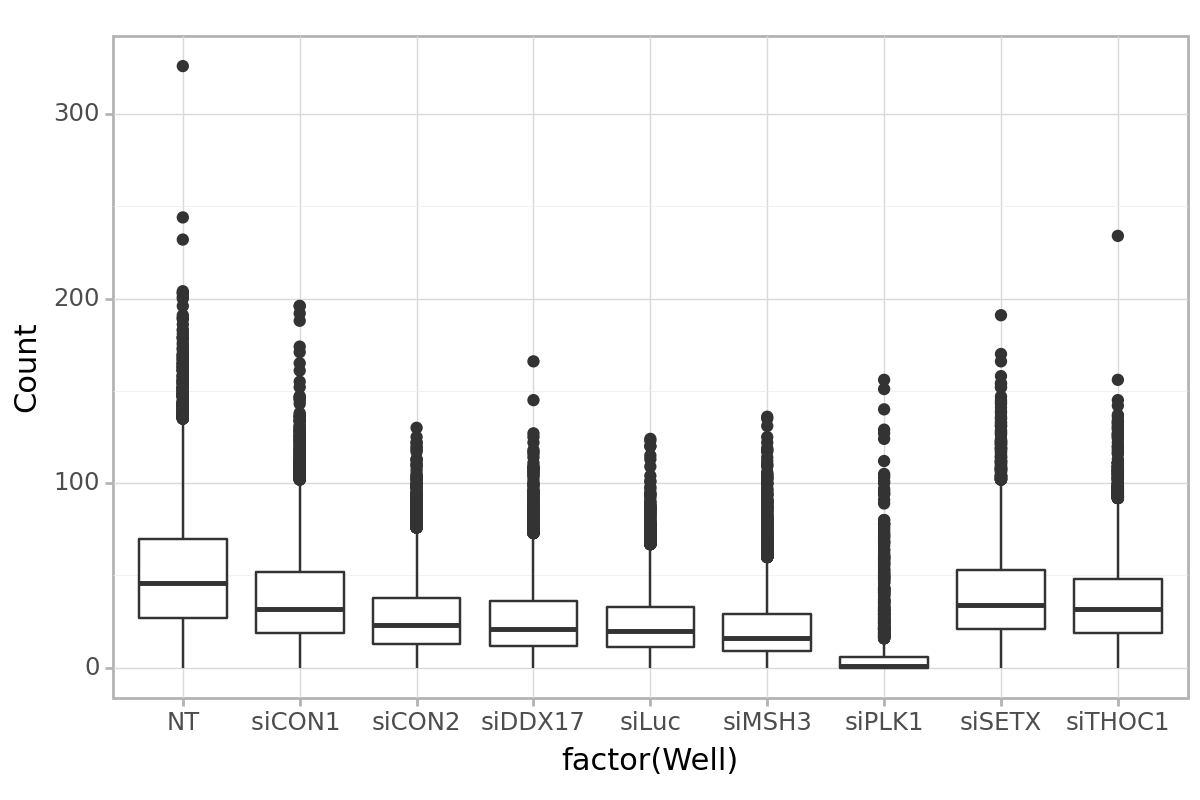

<Figure Size: (600 x 400)>

In [61]:
(
    ggplot(dose_0)
    + aes(x='Compound', y='Count')
    + geom_boxplot()
    + labs(x='factor(Well)', y='Count')
    + theme(figure_size=(6,4))
)

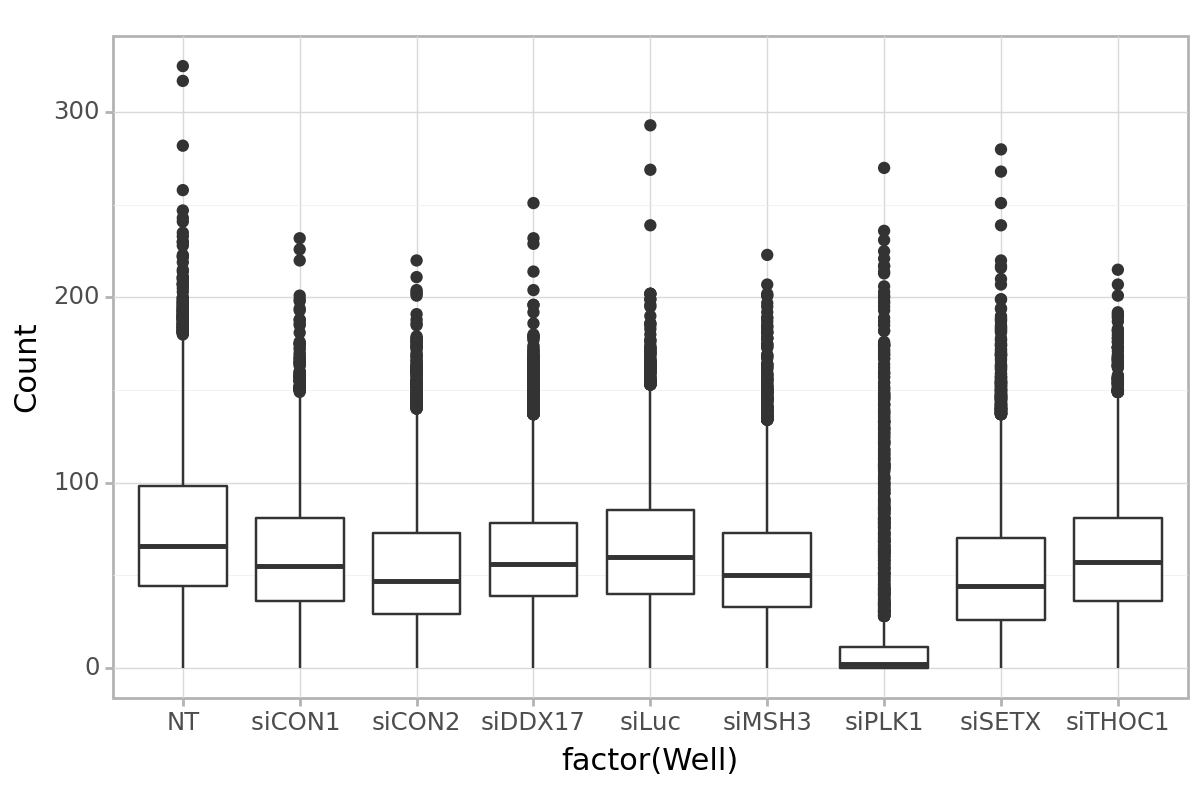

<Figure Size: (600 x 400)>

In [62]:
(
    ggplot(df.query('Dose==100'))
    + aes(x='Compound', y='Count')
    + geom_boxplot()
    + labs(x='factor(Well)', y='Count')
    + theme(figure_size=(6,4))
)

Scukneme vždy 3 jamky se stejnou compound a 0 nebo 100

In [56]:
df_deep_copy = df.copy()
df_deep_copy

,Well,AreaIndex,Count,Compound,Dose
0,128,1,2,NT,0
1,128,1,5,NT,0
2,128,1,40,NT,0
3,128,1,55,NT,0
4,128,1,29,NT,0
...,...,...,...,...,...
137638,257,100,106,NT,100
137639,257,100,70,NT,100
137640,257,100,282,NT,100
137641,257,100,58,NT,100


In [63]:
dict = {}
for row in df_deep_copy.iterrows():
    print(row)
    key = row['Compound']
    if key in dict.keys():
        dict[key] = dict[key].append((row['Count'], row['Dose']))
    else:
        dict[key] = []

(0, Well         128
AreaIndex      1
Count          2
Compound      NT
Dose           0
Name: 0, dtype: object)


IndexError: tuple index out of range

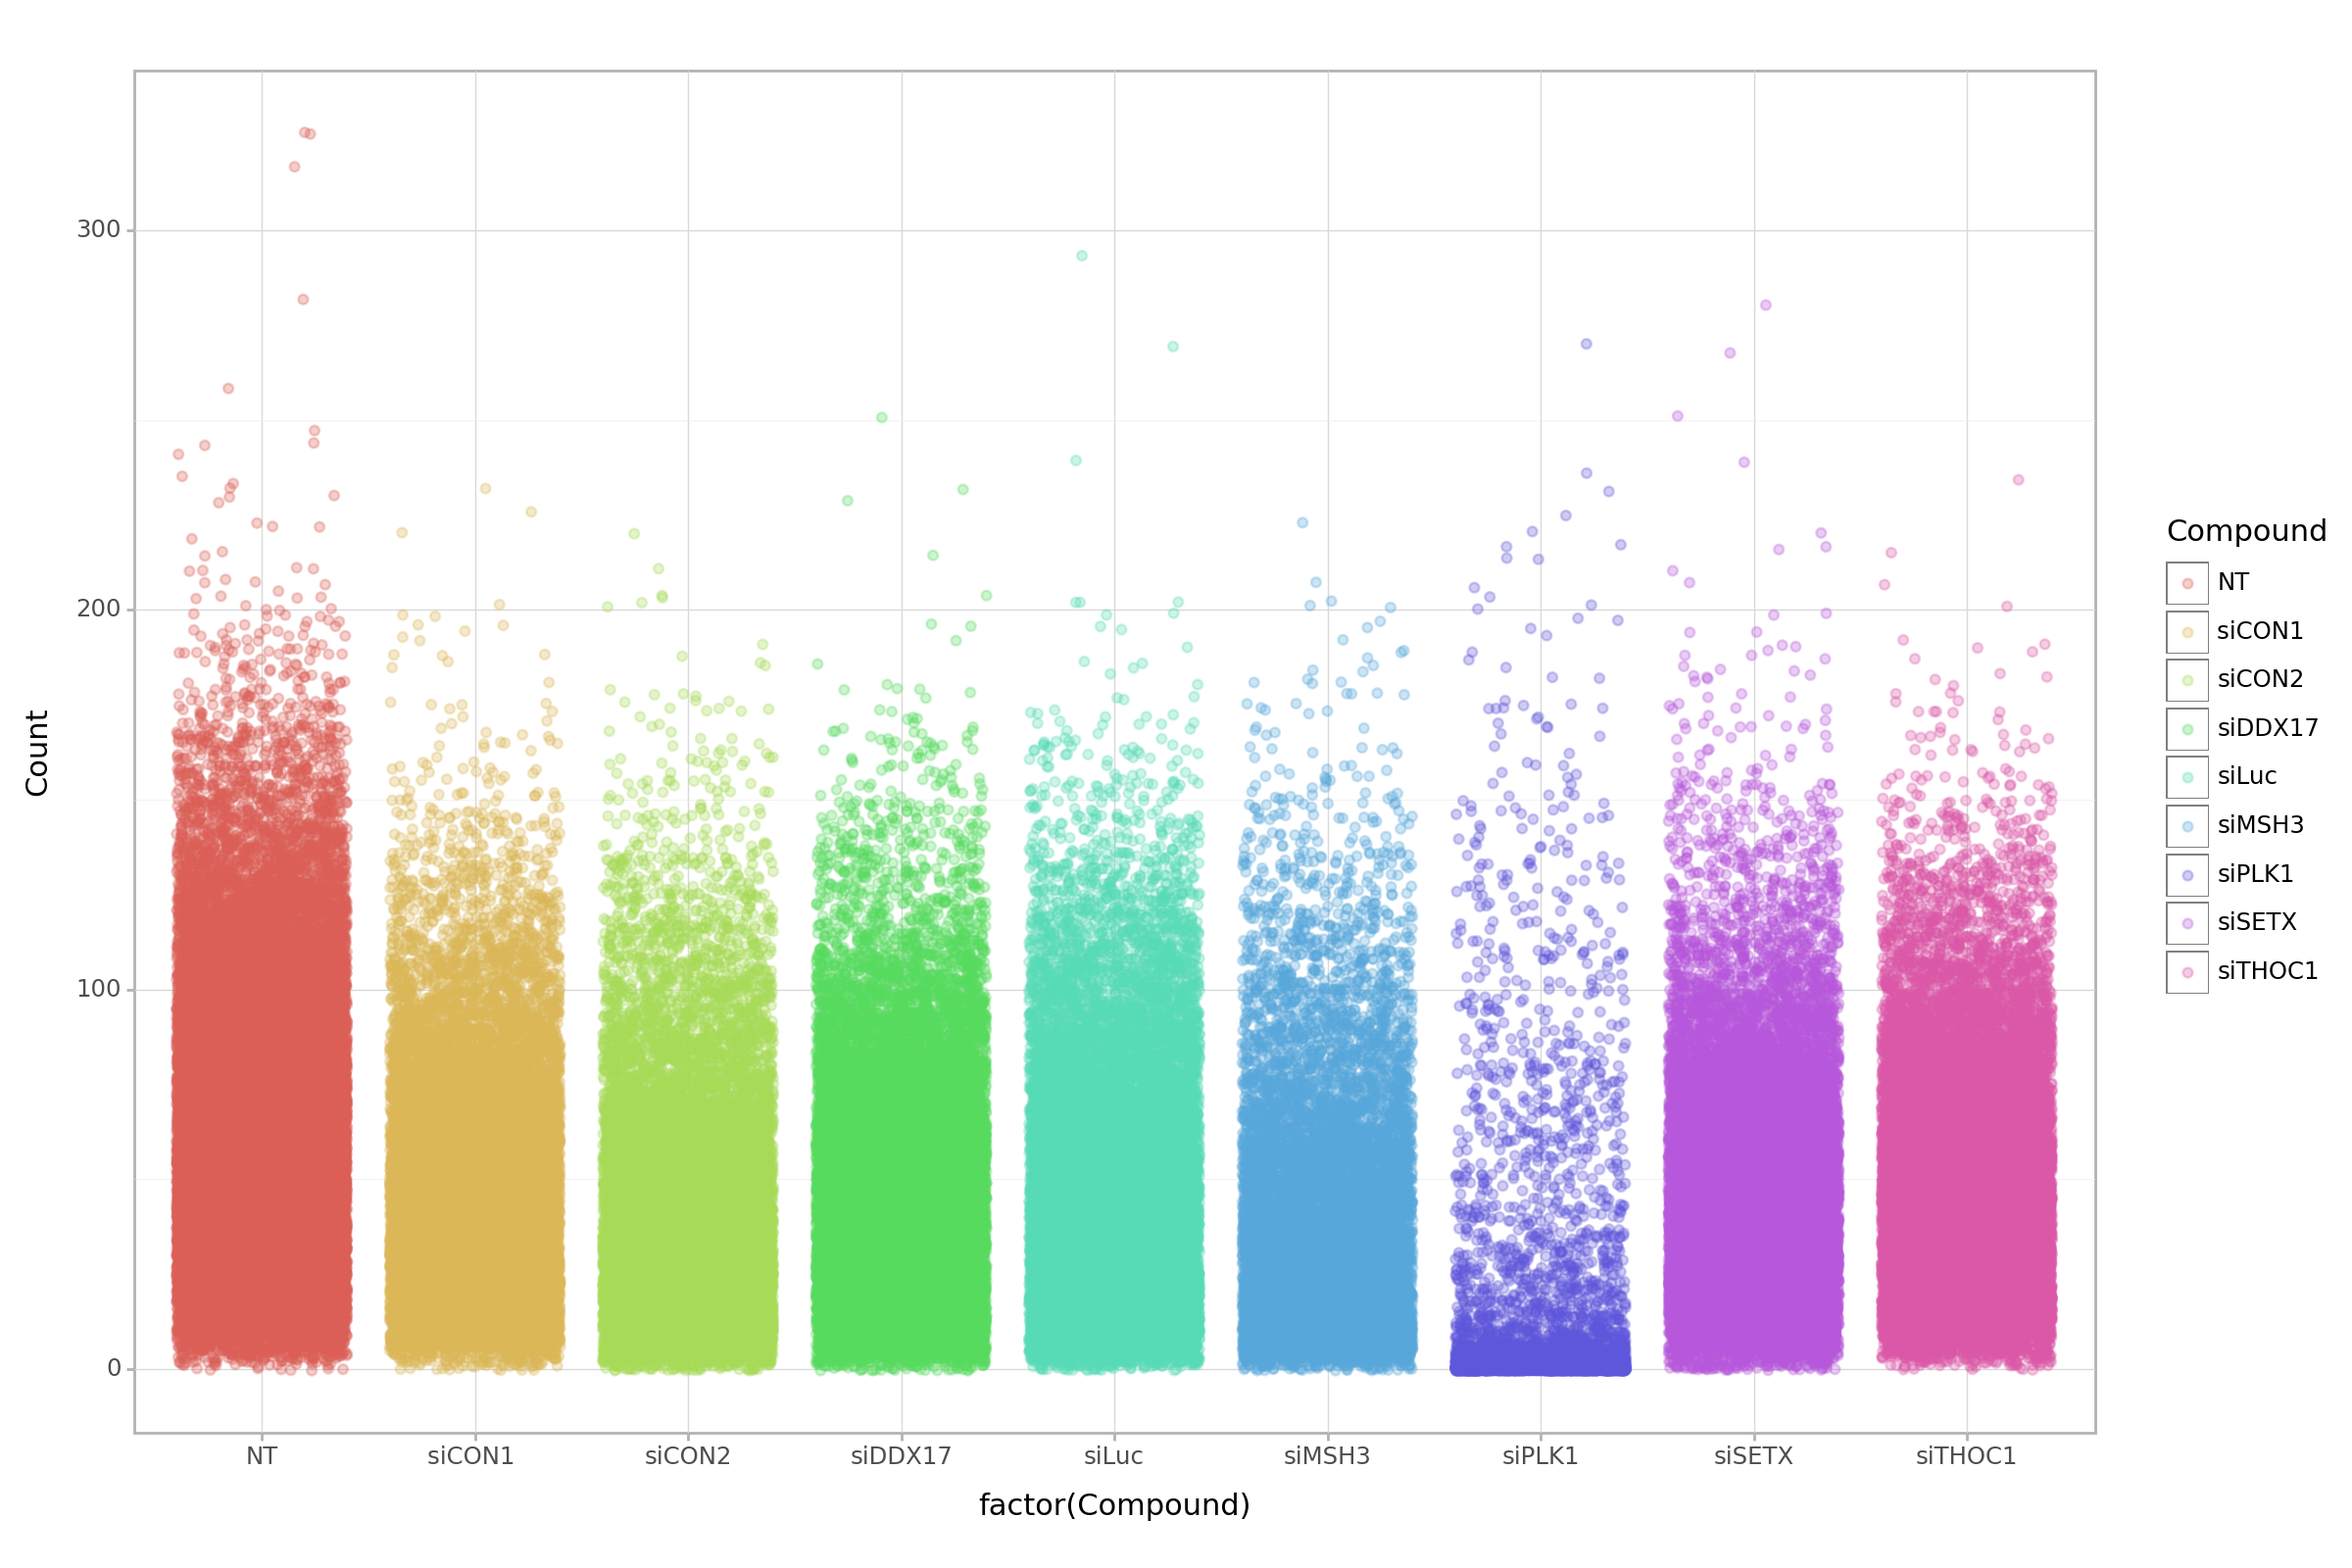

<Figure Size: (1200 x 800)>

In [35]:
(ggplot(df_by_comp)
 + aes(x="factor(Compound)", y='Count', color='Compound')
 + geom_jitter(alpha=.3)
 + theme(figure_size=(12,8))
)

In [ ]:
(ggplot(df)
 + aes(x='factor(Well)', y='Count', color='Compound')
 + geom_jitter(alpha=.3)
 + theme(figure_size=(12,8))
)

In [ ]:
(ggplot(df)
 + aes(x='factor(Well)', y='Count', color='Compound')
 + geom_boxplot()
 + theme(figure_size=(12,10))
)